In [1]:
import torch

In [2]:
from PIL import Image
import numpy as np

In [9]:
img = Image.open('clothing-dataset-small/train/pants/0098b991-e36e-4ef1-b5ee-4154b21e2a92.jpg')


In [11]:
# Resize to target size
img = img.resize((224, 224))

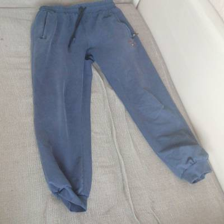

In [14]:
img

In [13]:
x = np.array(img)

print(x.shape)

(224, 224, 3)


## Pre-trained Models

In [19]:
import torchvision.models as models
from torchvision import transforms

# Load pre-trained model
model = models.mobilenet_v2(weights='IMAGENET1K_V1')
model.eval()

# Preprocessing for MobileNetV2
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /home/sagemaker-user/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 223MB/s]


In [25]:
img = Image.open('clothing-dataset-small/train/pants/0098b991-e36e-4ef1-b5ee-4154b21e2a92.jpg')
img_t = preprocess(img)
batch_t = torch.unsqueeze(img_t, 0)

# Make prediction
with torch.no_grad():
    output = model(batch_t)

# Get top predictions
_, indices = torch.sort(output, descending=True)

In [29]:
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt -O imagenet_classes.txt

# Load ImageNet class names
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]

# Get top 5 predictions
top5_indices = indices[0, :5].tolist()
top5_classes = [categories[i] for i in top5_indices]

print("Top 5 predictions:")
for i, class_name in enumerate(top5_classes):
    print(f"{i+1}: {class_name}")

--2025-12-01 12:51:30--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10472 (10K) [text/plain]
Saving to: ‘imagenet_classes.txt’

imagenet_classes.tx 100%[===================>]  10.23K  --.-KB/s    in 0s      

2025-12-01 12:51:31 (106 MB/s) - ‘imagenet_classes.txt’ saved [10472/10472]

Top 5 predictions:
1: jean
2: suit
3: cardigan
4: sweatshirt
5: overskirt


## Convolutional Neural Networks

In [30]:
# Custom Dataset Class
# First, create a PyTorch Dataset to load images:


import os
from torch.utils.data import Dataset

class ClothingDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.classes = sorted(os.listdir(data_dir))
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}

        for label_name in self.classes:
            label_dir = os.path.join(data_dir, label_name)
            for img_name in os.listdir(label_dir):
                self.image_paths.append(os.path.join(label_dir, img_name))
                self.labels.append(self.class_to_idx[label_name])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [31]:
input_size = 224

# ImageNet normalization values
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Simple transforms - just resize and normalize
train_transforms = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

val_transforms = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])